<a href="https://colab.research.google.com/github/CharuniPremarathne/Assignment_DL/blob/main/NasNetMobile%2BefficientNetV2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import time

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/rp/Dataset.zip /content

In [ ]:
!unzip -q DatasetNN.zip -d /content/Dataset

replace /content/Dataset/DatasetNN/test/AMD/amd_test_1001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = "/content/Dataset/Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/val"
test_dir = data_dir + "/test"

In [ ]:
# Initialize an ImageDataGenerator object for augmenting and processing training data.
train_datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale the pixel values of the images to the range [0, 1].
        rotation_range=10,  # Randomly rotate the images by a maximum of 10 degrees.
        horizontal_flip=True  # Flip the images horizontally (left to right) randomly.
)

# Create a generator using the ImageDataGenerator to load and process images from a directory.
train_gen = train_datagen.flow_from_directory(
        train_dir,  # Path to the directory containing the training images.
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize the images to a specified size (e.g., (256, 256)).
        batch_size=BATCH_SIZE,  # Number of images in each batch during training.
        class_mode='categorical',  # Type of labels for the classes ('categorical' for one-hot encoded labels).
        classes=['ARMD', 'NORMAL']  # Explicitly define the classes and their order.
)


Found 4600 images belonging to 2 classes.


In [ ]:
# Retrieve the dictionary containing the mapping of class names to numerical indices
# from the ImageDataGenerator object used to generate training data.
train_gen.class_indices

# For example, if the classes are 'DME' and 'NORMAL', the dictionary might look like this:
# {'DME': 0, 'NORMAL': 1}


{'AMD': 0, 'NORMAL': 1}

In [ ]:
# Initialize an ImageDataGenerator object for augmenting and processing validation (or test) data.
valid_datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale the pixel values of the images to the range [0, 1].
        rotation_range=10,  # Randomly rotate the images by a maximum of 10 degrees.
        horizontal_flip=True  # Flip the images horizontally (left to right) randomly.
)

# Create a generator using the ImageDataGenerator to load and process images from a directory for validation.
valid_gen = valid_datagen.flow_from_directory(
        valid_dir,  # Path to the directory containing the validation (or test) images.
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize the images to a specified size (e.g., (256, 256)).
        batch_size=BATCH_SIZE,  # Number of images in each batch during validation.
        class_mode='categorical',  # Type of labels for the classes ('categorical' for one-hot encoded labels).
        classes=['ARMD', 'NORMAL']  # Explicitly define the classes and their order.
)

Found 700 images belonging to 2 classes.


In [ ]:
# Initialize an ImageDataGenerator object for augmenting and processing test data.
test_datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale the pixel values of the images to the range [0, 1].
        rotation_range=10,  # Randomly rotate the images by a maximum of 10 degrees.
        horizontal_flip=True  # Flip the images horizontally (left to right) randomly.
)

# Create a generator using the ImageDataGenerator to load and process test images from a directory.
test_gen = test_datagen.flow_from_directory(
        test_dir,  # Path to the directory containing the test images.
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize the images to a specified size (e.g., (256, 256)).
        batch_size=BATCH_SIZE,  # Number of images in each batch during testing.
        class_mode='categorical',  # Type of labels for the classes ('categorical' for one-hot encoded labels).
        classes=['ARMD', 'NORMAL']  # Explicitly define the classes and their order.
)


Found 700 images belonging to 2 classes.


models

NASNetMobile

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

def inception_model(input_shape, n_classes):
    # Create an Xception base model with pre-trained weights from ImageNet
    base_model = tf.keras.applications.NASNetMobile(input_shape=input_shape, include_top=False, weights="imagenet")

    # Freeze the weights of the pre-trained Xception model
    base_model.trainable = False

    # Define the input tensor for the model
    inputs = Input(shape=input_shape)

    # Pass the input through the base model (Xception) without training its weights
    x = base_model(inputs, training=False)

    # Perform global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Apply dropout for regularization to prevent overfitting
    x = Dropout(0.15)(x)

    # Define the activation function and number of units for the output layer
    activation = "softmax"
    units = n_classes

    # Apply another dropout layer for regularization
    x = Dropout(0.2)(x)

    # Create a dense layer for the final prediction with specified activation function
    prediction_layer = Dense(units, activation=activation)

    # Connect the dense layer to the previous layer (x)
    outputs = prediction_layer(x)

    # Create the final model with input and output tensors
    model = Model(inputs, outputs)

    # Return the constructed model
    return model

In [ ]:
# Call the xception_model function to create an instance of the model
inception_model = inception_model(input_shape, n_classes)

# Display a summary of the model's architecture
inception_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098   

In [ ]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 10
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)


inception_model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)
# Compile the Xception model with the specified optimizer, loss function, and metrics

In [ ]:
# Train the Xception model using the fit method
inception_history_freeze = inception_model.fit(
    train_gen,                    # Training data generator
    epochs=10,        # Number of training epochs
    validation_data=valid_gen,    # Validation data generator
    callbacks=[callback, reduce_lr],  # Callbacks for early stopping and learning rate reduction
    shuffle=True                  # Shuffle the training data for each epoch
)

Epoch 1/10
144/144 [==============================] - 50s 284ms/step - loss: 0.3187 - accuracy: 0.8841 - val_loss: 0.0886 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 2/10
144/144 [==============================] - 36s 253ms/step - loss: 0.1197 - accuracy: 0.9600 - val_loss: 0.0397 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/10
144/144 [==============================] - 35s 246ms/step - loss: 0.0821 - accuracy: 0.9713 - val_loss: 0.0524 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 4/10
144/144 [==============================] - 36s 251ms/step - loss: 0.0813 - accuracy: 0.9752 - val_loss: 0.0508 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 5/10
144/144 [==============================] - 36s 253ms/step - loss: 0.0708 - accuracy: 0.9759 - val_loss: 0.0535 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/10
144/144 [==============================] - 36s 251ms/step - loss: 0.0707 - accuracy: 0.9785 - val_loss: 0.0669 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 7/10
144/144 [==============================] 

In [ ]:
# acc = [0.] + inception_history_freeze.history['accuracy']
# val_acc = [0.] + inception_history_freeze.history['val_accuracy']

# loss = inception_history_freeze.history['loss']
# val_loss = inception_history_freeze.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,2.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
# base_inception_model = inception_model.layers[1]
# base_inception_model.trainable = True

# fine_tune_at = 110

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_inception_model.layers[:fine_tune_at]:
#     layer.trainable = False

# optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
# loss = 'categorical_crossentropy'
# metrics = ['accuracy']
# callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

# inception_model.compile(optimizer = optimizer,
#                         loss = loss,
#                         metrics = metrics)

In [ ]:
# # Preview the Model Summary
# inception_model.summary()

In [ ]:
# fine_tune_epochs = 10 # Define the number of fine-tuning epochs
# total_epochs =  initial_epochs + fine_tune_epochs # Calculate the total epochs for training (initial + fine-tuning)

# inception_history_fine = xception_model.fit(
#     train_gen,# Training data generator providing batches of training data
#     epochs=total_epochs,  # Total number of epochs for training, including initial and fine-tuning epochs
#     initial_epoch = xception_history_freeze.epoch[-1],# Start training from the last epoch of the previous training (fine-tuning)
#     callbacks=[callback, reduce_lr],  # List of callbacks: EarlyStopping and ReduceLROnPlateau
#     validation_data=valid_gen,  # Validation data generator for model evaluation after each epoch
#     shuffle=True  # Shuffle the training data before each epoch to avoid learning order dependencies
# )

In [ ]:
# acc = [0.] + inception_history_fine.history['accuracy']
# val_acc = [0.] + inception_history_fine.history['val_accuracy']

# loss = inception_history_fine.history['loss']
# val_loss = inception_history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,3.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
inception_model.save('/content/drive/MyDrive/rp/inception/3.keras')

EfficientNetV2B1

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

def efficient_model(input_shape, n_classes):
    # Create an Xception base model with pre-trained weights from ImageNet
    base_model = tf.keras.applications.EfficientNetV2B1(input_shape=input_shape, include_top=False, weights="imagenet")

    # Freeze the weights of the pre-trained Xception model
    base_model.trainable = False

    # Define the input tensor for the model
    inputs = Input(shape=input_shape)

    # Pass the input through the base model (Xception) without training its weights
    x = base_model(inputs, training=False)

    # Perform global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Apply dropout for regularization to prevent overfitting
    x = Dropout(0.15)(x)

    # Define the activation function and number of units for the output layer
    activation = "softmax"
    units = n_classes

    # Apply another dropout layer for regularization
    x = Dropout(0.2)(x)

    # Create a dense layer for the final prediction with specified activation function
    prediction_layer = Dense(units, activation=activation)

    # Connect the dense layer to the previous layer (x)
    outputs = prediction_layer(x)

    # Create the final model with input and output tensors
    model = Model(inputs, outputs)

    # Return the constructed model
    return model

In [ ]:
# Call the xception_model function to create an instance of the model
efficient_model = efficient_model(input_shape, n_classes)

# Display a summary of the model's architecture
efficient_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 4, 4, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                            

In [ ]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 15
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)


efficient_model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metrics)
# Compile the Xception model with the specified optimizer, loss function, and metrics

In [ ]:
# Train the Xception model using the fit method
efficient_history_freeze = efficient_model.fit(
    train_gen,                    # Training data generator
    epochs=15,        # Number of training epochs
    validation_data=valid_gen,    # Validation data generator
    callbacks=[callback, reduce_lr],  # Callbacks for early stopping and learning rate reduction
    shuffle=True                  # Shuffle the training data for each epoch
)

Epoch 1/15
144/144 [==============================] - 55s 296ms/step - loss: 0.6849 - accuracy: 0.5626 - val_loss: 0.6552 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
144/144 [==============================] - 37s 255ms/step - loss: 0.6339 - accuracy: 0.6441 - val_loss: 0.5995 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 3/15
144/144 [==============================] - 38s 263ms/step - loss: 0.6038 - accuracy: 0.6909 - val_loss: 0.5681 - val_accuracy: 0.7514 - lr: 0.0010
Epoch 4/15
144/144 [==============================] - 38s 263ms/step - loss: 0.5760 - accuracy: 0.7211 - val_loss: 0.5439 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/15
144/144 [==============================] - 38s 264ms/step - loss: 0.5651 - accuracy: 0.7254 - val_loss: 0.5806 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 6/15
144/144 [==============================] - 42s 294ms/step - loss: 0.5565 - accuracy: 0.7213 - val_loss: 0.5258 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 7/15
144/144 [==============================] 

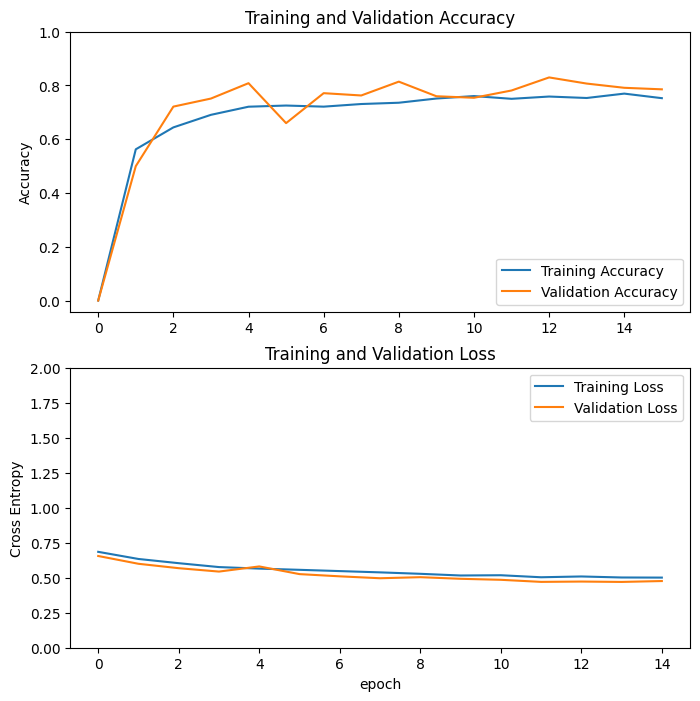

In [ ]:
acc = [0.] + efficient_history_freeze.history['accuracy']
val_acc = [0.] + efficient_history_freeze.history['val_accuracy']

loss = efficient_history_freeze.history['loss']
val_loss = efficient_history_freeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# base_efficient_model = efficient_model.layers[1]
# base_efficient_model.trainable = True

# fine_tune_at = 110

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_efficient_model.layers[:fine_tune_at]:
#     layer.trainable = False

# optimizer = Adam(learning_rate = 0.1 * base_learning_rate)
# loss = 'categorical_crossentropy'
# metrics = ['accuracy']
# callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)

# efficient_model.compile(optimizer = optimizer,
#                         loss = loss,
#                         metrics = metrics)

In [ ]:
# fine_tune_epochs = 10 # Define the number of fine-tuning epochs
# total_epochs =  10 + fine_tune_epochs # Calculate the total epochs for training (initial + fine-tuning)

# efficient_history_fine = efficient_model.fit(
#     train_gen,# Training data generator providing batches of training data
#     epochs=total_epochs,  # Total number of epochs for training, including initial and fine-tuning epochs
#     initial_epoch = efficient_history_freeze.epoch[-1],# Start training from the last epoch of the previous training (fine-tuning)
#     callbacks=[callback, reduce_lr],  # List of callbacks: EarlyStopping and ReduceLROnPlateau
#     validation_data=valid_gen,  # Validation data generator for model evaluation after each epoch
#     shuffle=True  # Shuffle the training data before each epoch to avoid learning order dependencies
# )

Epoch 10/30
144/144 [==============================] - 50s 308ms/step - loss: 1.1795 - accuracy: 0.5111 - val_loss: 0.6604 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 11/30
144/144 [==============================] - 41s 285ms/step - loss: 0.7197 - accuracy: 0.6087 - val_loss: 0.3387 - val_accuracy: 0.8829 - lr: 1.0000e-04
Epoch 12/30
144/144 [==============================] - 41s 285ms/step - loss: 0.3391 - accuracy: 0.8667 - val_loss: 0.2029 - val_accuracy: 0.9329 - lr: 1.0000e-04
Epoch 13/30
144/144 [==============================] - 41s 284ms/step - loss: 0.1667 - accuracy: 0.9385 - val_loss: 0.1992 - val_accuracy: 0.9243 - lr: 1.0000e-04
Epoch 14/30
144/144 [==============================] - 41s 283ms/step - loss: 0.1593 - accuracy: 0.9404 - val_loss: 0.1395 - val_accuracy: 0.9514 - lr: 1.0000e-04
Epoch 15/30
144/144 [==============================] - 41s 282ms/step - loss: 0.1143 - accuracy: 0.9602 - val_loss: 0.1054 - val_accuracy: 0.9686 - lr: 1.0000e-04
Epoch 16/30
144/144 [=

KeyboardInterrupt: 

In [ ]:
# acc = [0.] + efficient_history_fine.history['accuracy']
# val_acc = [0.] + efficient_history_fine.history['val_accuracy']

# loss = efficient_history_fine.history['loss']
# val_loss = efficient_history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,3.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
efficient_model.save('/content/drive/MyDrive/rp/efficient/3.h5')

hybrid

In [ ]:
# Load the pre-trained models
inception_model = load_model('/content/drive/MyDrive/rp/inception/3.keras')
efficient_model = load_model('/content/drive/MyDrive/rp/efficient/3.keras')

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

def inception_efficient_hybrid_model():
    # Create an input layer for the hybrid model
    input_layer = Input(shape=input_shape, name='input_layer')

    # Get the output from the custom CNN model
    inception_output = inception_model(input_layer)

    # Get the output from the MobileNet model
    efficient_output = efficient_model(input_layer)

    # Concatenate the outputs from both models
    concatenated_outputs = Concatenate()([inception_output, efficient_output])

    # Dense layers with dropout for regularization
    dense_layer1 = Dense(128, activation='relu')(concatenated_outputs)
    dropout1 = Dropout(0.5)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense_layer2)

    output_layer = Dense(n_classes, activation='softmax', name='output_layer')(dropout2)

    # Create the hybrid model
    inception_efficient_hybrid_model = Model(inputs=input_layer, outputs=output_layer, name='inception_efficient_hybrid_model')

    # Compile the model
    inception_efficient_hybrid_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Display model summary
    inception_efficient_hybrid_model.summary()

    return inception_efficient_hybrid_model

In [ ]:
def train_inception_efficient_hybrid_model(model):
    # Early Stopping
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Reduce the learning rate when a model has stopped improving.
    learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=12, verbose=1, factor=0.5, min_lr=0.00001)

    history = callbacks.History()

    model.fit(
        train_gen,
        batch_size=BATCH_SIZE,
        validation_data=valid_gen,
        verbose=1,
        epochs=8,
        callbacks=[early_stopping, learning_rate_reduction, history]
    )

    model.save('/content/drive/MyDrive/rp/hybrid/3.keras')

    return model

In [ ]:
# Define the model
inception_efficient_hybrid_model = inception_efficient_hybrid_model()
# Train the model
train_inception_efficient_hybrid_model(inception_efficient_hybrid_model)

Model: "inception_efficient_hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 2)                    2180688   ['input_layer[0][0]']         
                                                          2                                       
                                                                                                  
 model_1 (Functional)        (None, 2)                    1078660   ['input_layer[0][0]']         
                                                          9                                       
                                                                   

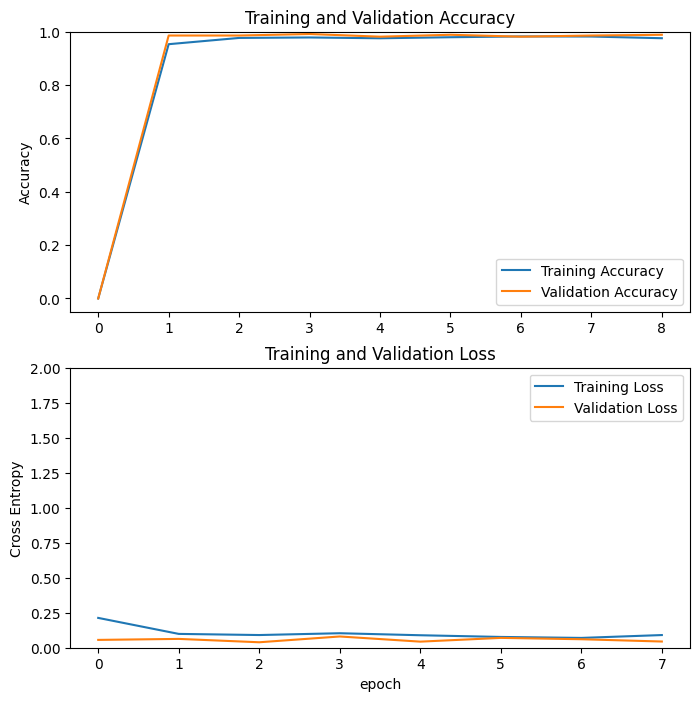

In [ ]:
acc = [0.] + inception_efficient_hybrid_model.history.history['accuracy']
val_acc = [0.] + inception_efficient_hybrid_model.history.history['val_accuracy']

loss = inception_efficient_hybrid_model.history.history['loss']
val_loss = inception_efficient_hybrid_model.history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()